### Performing checks for the resources available

In [129]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Installing huggingface transformers library

In [130]:
!pip install transformers

## Importing necessary packages

In [131]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import time
import datetime
from sklearn.metrics import classification_report,confusion_matrix
import random
import time
import torch.nn as nn
from transformers import AutoModel , AutoModelForSequenceClassification, AutoConfig , AutoTokenizer , AdamW ,get_linear_schedule_with_warmup
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

## Setting some configuration values

In [132]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,12)

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## Importing drive into the colaboratory

In [133]:
# from google.colab import drive
# drive.mount('/content/drive')

## Loading training data

In [134]:
import pandas as pd

# Attempt to read the file with ISO-8859-1 encoding
data = pd.read_excel('/content/Final_clean pro 2.xlsx')


In [135]:
# Add an ID column starting from 1
data['PID'] = range(1, len(data) + 1)

In [136]:
data.head()

,Comments,Label,PID
0,তোমরা সবাই এই ভাই তাকে একটু কোরোভিডিও গুলো দে...,positive,1
1,🎯 ব্রহ্মপুত্র নদের ওপর নির্মিত ৯.১৫ কিলোমিটারে...,positive,2
2,😊 ধন্যবাদ মাননীয় প্রধানমন্ত্রী শেখ হাসিনা,positive,3
3,2022 এর 25 এ জুন 🥰🥰,neutral,4
4,অনুভূতিটা এত সুন্দর ভাষায় প্রকাশ করতে পারতেছি...,positive,5


In [137]:
import pandas as pd

# Function to rename a single column
def change_column_name(df, old_name, new_name):
    df = df.rename(columns={old_name: new_name})
    return df

# Assuming df is your DataFrame
data = change_column_name(data, old_name="Label", new_name="labels")
data = change_column_name(data, old_name="Comments", new_name="text")
data.head() # Display the first few rows of the DataFrame
#text


# Move the ID column to the first position
cols = ['PID'] + [col for col in data.columns if col != 'PID']
data = data[cols]

data.head()

,PID,text,labels
0,1,তোমরা সবাই এই ভাই তাকে একটু কোরোভিডিও গুলো দে...,positive
1,2,🎯 ব্রহ্মপুত্র নদের ওপর নির্মিত ৯.১৫ কিলোমিটারে...,positive
2,3,😊 ধন্যবাদ মাননীয় প্রধানমন্ত্রী শেখ হাসিনা,positive
3,4,2022 এর 25 এ জুন 🥰🥰,neutral
4,5,অনুভূতিটা এত সুন্দর ভাষায় প্রকাশ করতে পারতেছি...,positive


In [138]:


# Keep only the specified three columns
# Replace 'column1', 'column2', 'column3' with your actual column names
data = data[['PID', 'text', 'labels']]

# Report the number of sentences
print('Number of training sentences: {:,}\n'.format(data.shape[0]))

# Display 10 random rows from the data
print(data.sample(10))


Number of training sentences: 6,375

       PID                                               text    labels
1912  1913  আওয়ামীলীগের আরেক নাম শেখ হাসিনার উন্নয়ন। আপা,...   neutral
5272  5273    আল্লাহ আপনি সবাইকে হেফাজত করেন আল্লাহুম্মা আমিন  positive
5230  5231  দুর্ঘটনা তো ঘটবেই... আল্লাহ নারাজ সবার উপরে। য...  negative
4231  4232  সবার উপরে মানুষ সত্য ❤কথাটা আজকে মিথ্যা প্রমান...  positive
5890  5891  এত বড় একটা পদ্মা সেতু কোন আলেম-ওলামা দিয়ে মো...  positive
233    234  আমাদের টাকায় হলে চায়না কেন পয়ত্রিশ বছর টোল ...   neutral
2576  2577                 ১১ বিলিয়নের মধ্যে ৫ বিলিয়ন হাস্যকর  negative
296    297                           পাটুরিয়া একটা সেতু দরকার   neutral
4882  4883  আমার বরিশালের সপ্নের সেতু সাবাশ বাংলাদেশ ধন্যব...  positive
2915  2916  এত টাকা লাগবে বলছেন ২০ লাখ টাকা দিয়ে সারিয়ে ...   neutral


In [139]:
import pandas as pd
from sklearn.model_selection import train_test_split

# # Read the file with ISO-8859-1 encoding
# train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Nazir Sir/spam - spam.csv', encoding='ISO-8859-1')

# First, split the data into training and temp (test + validation)
train_df, temp_df = train_test_split(data, test_size=0.2, random_state=42)

# Then split temp_data into test and validation sets (50% each of temp_data, so 15% of the total for each)
test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [140]:
train_df

,PID,text,labels
2199,2200,গ্রাম নাম কি?,neutral
471,472,এখানে যেমন উন্নত তুলে ধরা হয়েছে ঠিক সেইভাবে দ...,neutral
3402,3403,বেটা পাইছোস এক কোভিড। সব দোষ কোভিড ঘোষ,negative
4224,4225,আমার নেত্রী আমার মা জননেত্রী শেখ হাসিনা আমরা প...,positive
1471,1472,আসসালামু আলাইকুম আপু,neutral
...,...,...,...
3772,3773,মানুষ বেঁচে না থাকলে মেট্রোরেলে চরবে কারা?! আগ...,positive
5191,5192,পদ্মা সেতুর পাসে নদীর মাঝে বিদ্যুৎ এর টাওয়ারের...,negative
5226,5227,নিশ্চয়ই জামাত শিবিরের চক্রান্ত আছে এখানে,negative
5390,5391,পদ্মার নিচে কোন খারাপ জিনের আছর আছে নাকি সেটা ...,negative


In [141]:
test_df

,PID,text,labels
5344,5345,উলঙ্গ নারী দের পাসে রেখে ৯৬% মুসলমানের বাংলাদে...,negative
5300,5301,"হুজুরে আকা বাকা দোয়া করে দিয়েছেন , তাই ড্রাইভা...",neutral
5363,5364,জনগণের ট্যাক্সের টাকায় পদ্মা সেতু কিন্তু আবার...,neutral
349,350,ধন্যবাদ মানিয় শেখ হাসিনা ❤️❤️🤲,positive
5987,5988,তাহলে এখন পদ্মা সেতুতে ট্রাক চলাচল নিষিদ্ধ করা...,negative
...,...,...,...
598,599,পদ্মা সেতু বানাতে 30 হাজার কোটি টাকা খরচ হয় স...,negative
135,136,"অসাধারণ গান,শেখের বেটি আবার দেখিয়ে দিলো,শেখ হা...",positive
5971,5972,বেপরোয়া ড্রাইভিং-এর কারনে।,negative
4590,4591,"কথাই আছেভাত পাই না চা চাই,,,,,,।",positive


In [142]:
val_df

,PID,text,labels
5831,5832,&;উন্মাদের মত চালালে গাড়ি!দুর্ঘটনা হবে বারবার...,positive
318,319,আলহামদুলিল্লাহ গানের শুরুতেই সূর্যের পাশে যে ব...,positive
5192,5193,উমর ইনান ভাই সেরা 🥰🥰,positive
4087,4088,২০০০+ মানুষের লাশ দেখেন আগে। এরপর মেট্রোরেল দে...,negative
5076,5077,"আমার বাংলাদেশী মা ভাই বোন দের জানাই ভালোবাসা, ...",positive
...,...,...,...
5221,5222,আল্লাহর গজব। এখানে নর্তকি মানা না করে যদি দোয়া...,neutral
2820,2821,এই রেলপথ ও সড়কপথ ও যতোই সেতু নির্মিত হচ্ছে । এ...,positive
4280,4281,এরা আসলেই রাজাকার এরা এদেশের ভালো চায় নাহ,negative
4461,4462,শুধু মেগা না সবগুলো প্রকল্প দেখতে হবে।,neutral


In [143]:
train_df['labels'].value_counts()

,count
labels,
positive,2166
negative,1527
neutral,1407


In [144]:

le = LabelEncoder()
train_df['labels'] = le.fit_transform(train_df['labels'])

In [145]:
train_df['labels'].value_counts()

,count
labels,
2,2166
0,1527
1,1407


### Loading `train_sentences` and `train_labels`

In [146]:
# Get the lists of sentences and their labels.
train_sentences = train_df['text'].values
train_labels = train_df['labels'].values

## Saving Class Names

In [147]:
data.labels.unique()

array(['positive', 'neutral', 'negative'], dtype=object)

In [148]:
class_names = [
            'positive', 'neutral', 'negative'
]

## Loading the validation data

In [149]:
val_df['labels'] = le.transform(val_df['labels'])

In [150]:

val_df['labels'].value_counts()

,count
labels,
2,272
0,190
1,176


### Loading `val_sentences` and `val_labels`

In [151]:
# Get the lists of sentences and their labels.
val_sentences = val_df['text'].values
val_labels = val_df['labels'].values

In [152]:
val_labels

array([2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 2, 0, 0, 2, 2, 0, 2, 1,
       2, 0, 1, 2, 0, 1, 0, 1, 1, 0, 2, 1, 0, 1, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0, 2, 0, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 0, 1, 2, 1, 2, 2, 0, 0,
       2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 0, 0, 2, 1, 0, 2, 0, 2,
       2, 2, 0, 0, 2, 0, 1, 1, 1, 0, 2, 1, 0, 1, 1, 0, 0, 2, 0, 2, 1, 1,
       2, 1, 2, 0, 2, 0, 2, 2, 1, 0, 0, 2, 2, 0, 2, 1, 0, 1, 2, 0, 0, 0,
       2, 0, 1, 1, 0, 2, 2, 2, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 2, 1, 2, 2,
       1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 1, 2, 1, 2, 1, 1, 0, 2, 2, 2, 2, 1,
       2, 0, 0, 2, 1, 2, 0, 2, 1, 0, 0, 2, 1, 1, 0, 2, 0, 1, 1, 2, 0, 0,
       0, 1, 2, 2, 1, 0, 0, 0, 2, 2, 2, 1, 0, 2, 1, 0, 0, 0, 0, 1, 2, 2,
       1, 1, 1, 1, 0, 2, 2, 2, 1, 1, 1, 0, 2, 2, 0, 2, 2, 2, 1, 2, 2, 1,
       1, 2, 0, 2, 2, 2, 2, 1, 2, 1, 0, 2, 2, 1, 0, 1, 2, 0, 0, 0, 0, 0,
       2, 2, 0, 2, 2, 0, 1, 1, 1, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 1,
       0, 2, 1, 1, 1, 2, 0, 2, 0, 1, 2, 0, 1, 2, 1,

## Helper Functions

#### 1) Update Interval Function

In [153]:
def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller.
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

#### 2) Format time function

In [154]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


#### 3) Make Smart Batches function

In [155]:
def make_smart_batches(text_samples, labels, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(labels)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(labels), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_labels = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_labels = []

    # For each batch...
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_labels)


In [156]:
def make_smart_batches_on_test(text_samples, text_ids, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(text_samples)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(text_samples), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, text_ids), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_ids = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_ids.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_ids = []

    # For each batch...
    for (batch_inputs, batch_ids) in zip(batch_ordered_sentences, batch_ordered_ids):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_ids.append(torch.tensor(batch_ids))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_ids)


#### 4) Function for calculating accuracy per class

In [157]:
def accuracy_per_class(preds, labels , label_dict):

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict[label]}')
        print(f'Accuracy: {round(100*len(y_preds[y_preds==label])/len(y_true) , 2)}\n')

### 5) Function for plotting training history

In [158]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

### 6) Function to check accuracy

In [159]:
def check_accuracy(predictions,true_labels):
  # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  # Calculate simple flat accuracy -- number correct over total number.
  accuracy = (preds == true_labels).mean()

  return accuracy

### 7) Function to evaluate model

In [160]:
def eval_model(model,py_inputs, py_attn_masks, py_labels):
# Prediction on test set
  t0 = time.time()

  print('Doing validation on {:,} sentences...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()
  total_val_loss = 0

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
        output = model(b_input_ids,
                           #  token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)


      logits = output.logits
      loss = output.loss
      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)

      total_val_loss += loss.item()

  val_accuracy = check_accuracy(predictions,true_labels)

  validation_time = format_time(time.time() - t0)

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_val_loss / len(py_inputs)


  # print('Accuracy: {:.3f}'.format(val_accuracy))
  return (avg_val_loss,val_accuracy,validation_time)


### 8) Function for making predictions on our test dataset

In [161]:
def get_predictions(py_inputs, py_attn_masks, py_labels):

  print('Predicting labels for {:,} test batches...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

      # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return (preds,true_labels)

### 9) Function for making predictions on test dataset(without labels)

In [162]:
def get_predictions_test(py_inputs, py_attn_masks,py_ids):

  print('Predicting labels for {:,} test batches...'.format(len(py_inputs)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels ,ids = [], [] , []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_ids = py_ids[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      b_ids = b_ids.detach().cpu().numpy()
      # Store predictions
      predictions.append(logits)
      ids.append(b_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  ids = np.concatenate(ids,axis=0)
  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return ids,preds

### 10) Confusion Matrix Helper Function

In [163]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

## Smart Batching of the training data

In [164]:
#model_name = 'sagorsarker/bangla-bert-base'

#model_name = 'google-bert/bert-base-multilingual-cased'

#model_name = 'distilbert/distilbert-base-uncased'

model_name = 'FacebookAI/xlm-roberta-base'

#
# Load the BERT tokenizer.
print(f'Loading {model_name} tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

Loading FacebookAI/xlm-roberta-base tokenizer...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [165]:
lengths = []
for text in train_sentences:
  lengths.append(len(text))

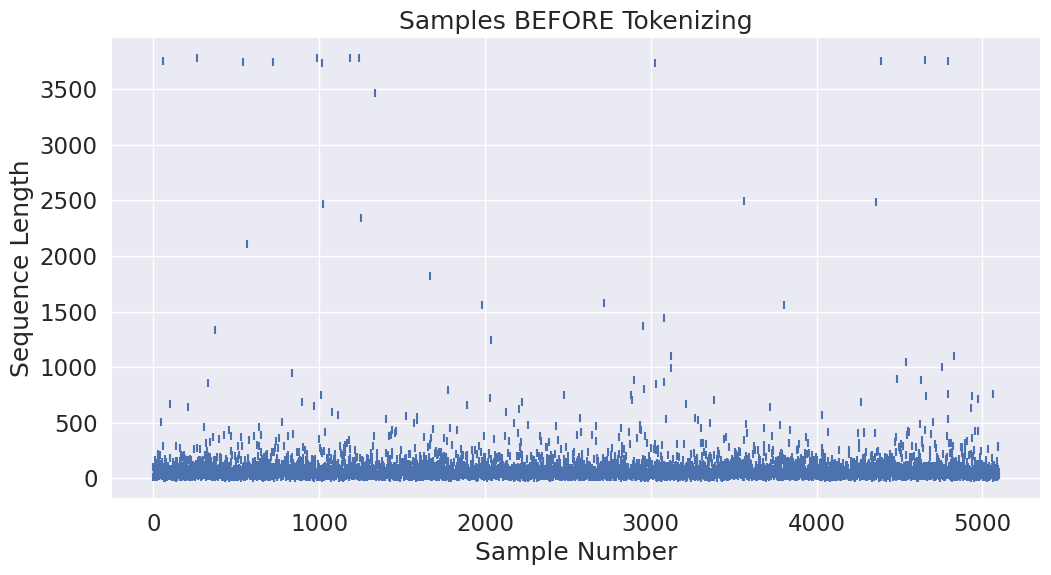

In [166]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(lengths)), lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Tokenizing')

plt.show()

### Tokenizing the sequences

In [167]:
max_input_length = 300

In [168]:
full_input_ids = []
labels = []

# Tokenize all training examples
print('Tokenizing {:,} training samples...'.format(len(train_sentences)))

# Choose an interval on which to print progress updates.
update_interval = good_update_interval(total_iters=len(train_sentences), num_desired_updates=10)

# For each training example...
for text in train_sentences:

    # Report progress.
    if ((len(full_input_ids) % update_interval) == 0):
        print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

    # Tokenize the sentence.
    input_ids = tokenizer.encode(text=text,
                                 add_special_tokens=True,
                                 max_length=max_input_length,
                                 truncation=True,
                                 padding=False)

    # Add the tokenized result to our list.
    full_input_ids.append(input_ids)

print('DONE.')
print('{:>10,} samples'.format(len(full_input_ids)))

Tokenizing 5,100 training samples...
  Tokenized 0 samples.
  Tokenized 500 samples.
  Tokenized 1,000 samples.
  Tokenized 1,500 samples.
  Tokenized 2,000 samples.
  Tokenized 2,500 samples.
  Tokenized 3,000 samples.
  Tokenized 3,500 samples.
  Tokenized 4,000 samples.
  Tokenized 4,500 samples.
  Tokenized 5,000 samples.
DONE.
     5,100 samples


In [169]:
# Get all of the lengths.
unsorted_lengths = [len(x) for x in full_input_ids]

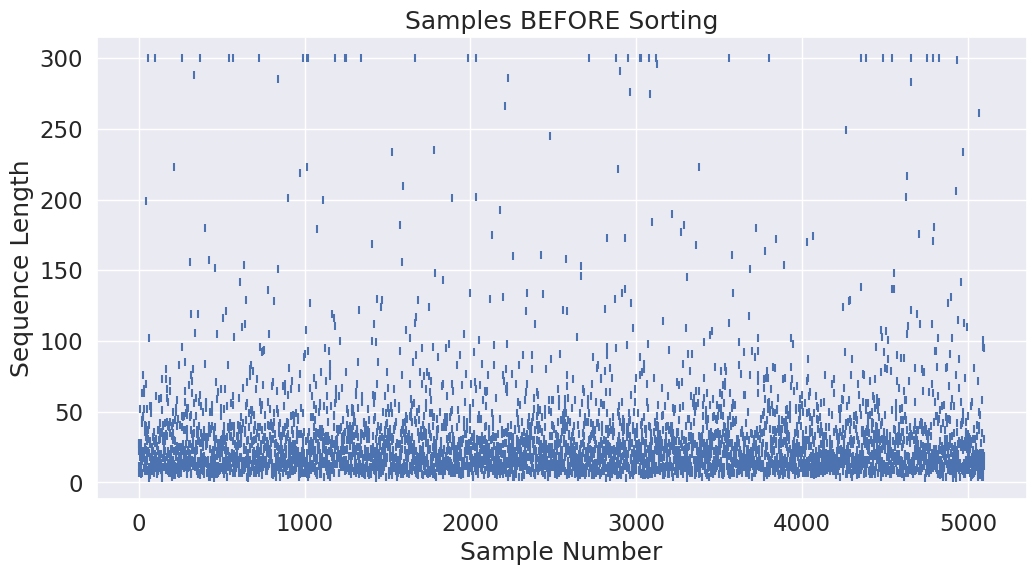

In [170]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')

plt.show()

In [171]:
# Sort the two lists together by the length of the input sequence.
train_samples = sorted(zip(full_input_ids, train_labels), key=lambda x: len(x[0]))

In [172]:
train_samples[0:5]

[([0, 147224, 2], 1),
 ([0, 230906, 2], 1),
 ([0, 107160, 2], 1),
 ([0, 46930, 2], 1),
 ([0, 144370, 2], 2)]

In [173]:
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 3
Longest sample: 300


In [174]:
# Get the new list of lengths after sorting.
sorted_lengths = [len(s[0]) for s in train_samples]

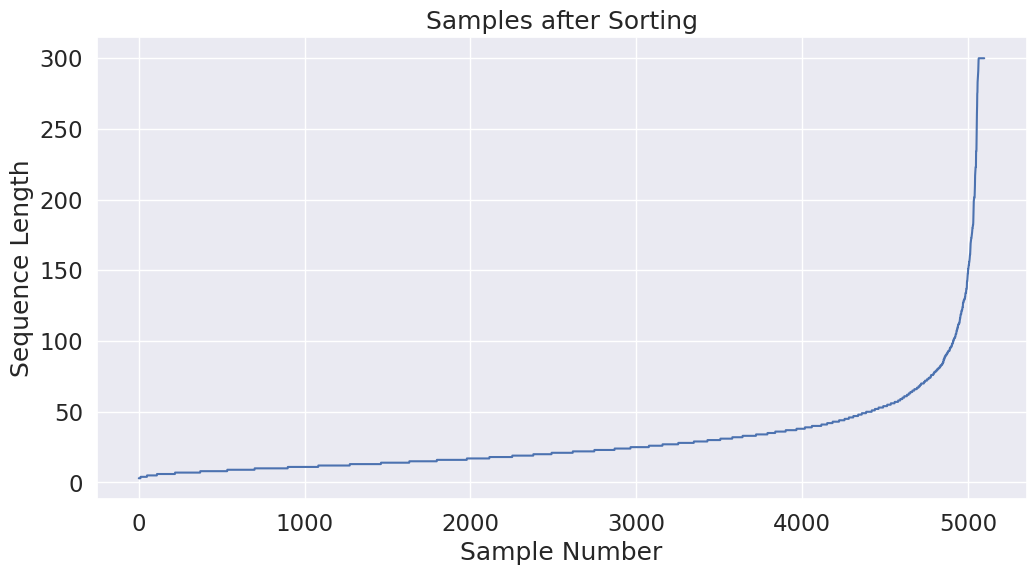

In [175]:


plt.plot(range(0, len(sorted_lengths)), sorted_lengths)

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples after Sorting')

plt.show()

### Random Batch Selections

In [176]:
train_samples[0]

([0, 147224, 2], 1)

In [177]:
batch_size = 16

In [178]:
# List of batches that we'll construct.
batch_ordered_sentences = []
batch_ordered_labels = []

print('Creating training batches of size {:}'.format(batch_size))

# Loop over all of the input samples...
while len(train_samples) > 0:

    # Report progress.
    if ((len(batch_ordered_sentences) % 100) == 0):
        print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

    # `to_take` is our actual batch size. It will be `batch_size` until
    # we get to the last batch, which may be smaller.
    to_take = min(batch_size, len(train_samples))

    # Pick a random index in the list of remaining samples to start
    # our batch at.
    select = random.randint(0, len(train_samples) - to_take)

    # Select a contiguous batch of samples starting at `select`.
    batch = train_samples[select:(select + to_take)]

    # Each sample is a tuple--split them apart to create a separate list of
    # sequences and a list of labels for this batch.
    batch_ordered_sentences.append([s[0] for s in batch])
    batch_ordered_labels.append([s[1] for s in batch])

    # Remove these samples from the list.
    del train_samples[select:select + to_take]

print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))

Creating training batches of size 16
  Selected 0 batches.
  Selected 100 batches.
  Selected 200 batches.
  Selected 300 batches.

  DONE - 319 batches.


In [179]:
print(batch_ordered_sentences[0])

[[0, 4577, 34653, 44201, 47886, 201078, 91866, 83661, 27372, 13171, 2], [0, 118428, 2763, 209444, 896, 30234, 5507, 27372, 9591, 32, 2], [0, 12945, 3397, 7163, 147491, 20895, 33237, 37555, 26782, 6155, 2], [0, 204461, 37564, 14940, 27372, 4480, 112592, 58851, 2730, 9591, 2], [0, 58041, 13705, 999, 9618, 157129, 956, 135241, 173989, 4480, 2], [0, 138606, 82548, 234678, 64248, 33338, 6, 243385, 243385, 243385, 2], [0, 21145, 44201, 9853, 2801, 53997, 71994, 3718, 18566, 125, 2], [0, 52968, 239400, 210966, 7185, 214942, 6, 115114, 115114, 115114, 2], [0, 46281, 61280, 209444, 131678, 12173, 42579, 114681, 230774, 73431, 2], [0, 52968, 6, 34619, 70904, 53509, 6, 211386, 227514, 4, 2], [0, 91560, 93971, 64785, 113607, 114508, 14940, 38727, 28856, 2145, 2], [0, 144370, 128474, 131363, 14940, 166101, 46234, 151414, 91560, 125, 2], [0, 82712, 93916, 896, 146145, 26020, 36358, 8751, 2763, 125, 2], [0, 29388, 114698, 15709, 2763, 11622, 167909, 6, 197283, 29982, 2], [0, 4979, 98715, 2937, 9755, 

In [180]:
batch_ordered_labels[0]

[1, 1, 2, 1, 0, 2, 2, 2, 0, 1, 1, 0, 0, 2, 1, 2]

### Padding

In [181]:
py_inputs = []
py_attn_masks = []
py_labels = []

# For each batch...
for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

    # New version of the batch, this time with padded sequences and now with
    # attention masks defined.
    batch_padded_inputs = []
    batch_attn_masks = []

    # First, find the longest sample in the batch.
    # Note that the sequences do currently include the special tokens!
    max_size = max([len(sen) for sen in batch_inputs])

    #print('Max size:', max_size)

    # For each input in this batch...
    for sen in batch_inputs:

        # How many pad tokens do we need to add?
        num_pads = max_size - len(sen)

        # Add `num_pads` padding tokens to the end of the sequence.
        padded_input = sen + [tokenizer.pad_token_id]*num_pads

        # Define the attention mask--it's just a `1` for every real token
        # and a `0` for every padding token.
        attn_mask = [1] * len(sen) + [0] * num_pads

        # Add the padded results to the batch.
        batch_padded_inputs.append(padded_input)
        batch_attn_masks.append(attn_mask)

    # Our batch has been padded, so we need to save this updated batch.
    # We also need the inputs to be PyTorch tensors, so we'll do that here.
    py_inputs.append(torch.tensor(batch_padded_inputs))
    py_attn_masks.append(torch.tensor(batch_attn_masks))
    py_labels.append(torch.tensor(batch_labels))


### Check the number of token reductions because of smart batching

In [182]:
# Get the new list of lengths after sorting.

padded_lengths = []

# For each batch...
for batch in py_inputs:

    # For each sample...
    for s in batch:

        # Record its length.
        padded_lengths.append(len(s))

# Sum up the lengths to the get the total number of tokens after smart batching.
smart_token_count = np.sum(padded_lengths)

# To get the total number of tokens in the dataset using fixed padding, it's
# as simple as the number of samples times our `max_len` parameter (that we
# would pad everything to).
fixed_token_count = len(train_sentences) * max_input_length

# Calculate the percentage reduction.
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count)

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))


Total tokens:
   Fixed Padding: 1,530,000
  Smart Batching: 171,552  (88.8% less)


## Load the model configuration from the transformers library using AutoConfig

In [183]:
# Load the Config object, with an output configured for classification.
config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name,
                                    num_labels=6)

print('Config type:', str(type(config)), '\n')


Config type: <class 'transformers.models.xlm_roberta.configuration_xlm_roberta.XLMRobertaConfig'> 



In [184]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name,config = config)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [185]:
model.cuda()

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768,

## Load the model from the transformers library using AutoModel

In [186]:
# Load the pre-trained model for classification, passing in the `config` from
# above.
bert = AutoModel.from_pretrained(
    pretrained_model_name_or_path=model_name,
    config=config)

print('\nModel type:', str(type(bert)))



Model type: <class 'transformers.models.xlm_roberta.modeling_xlm_roberta.XLMRobertaModel'>


In [187]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## Creating a custom BERT model

In [188]:

# class BERT_Model(nn.Module):
#     ## defining the constructor for the class
#     def __init__(self, bert,num_labels):
#       ## calling the super class constructor
#       super(BERT_Model, self).__init__()
#       ## adding the bert layer to the model
#       self.bert = bert
#       # relu activation function
#       self.relu =  nn.ReLU()
#       # adding a dense layer to our custom model
#       self.fc1 = nn.Linear(768,512)
#       # adding another dense layer to our custom model ,i.e., the Output layer
#       self.fc2 = nn.Linear(512,num_labels)
#       # adding a softmax  activation function for our custom model's output layer
#       self.softmax = nn.LogSoftmax(dim=1)

#     #defining the forward pass
#     def forward(self, input_id, mask):
#       #pass the inputs to the model
#       outputs = self.bert(input_id,mask)

#       last_hidden_state = outputs.last_hidden_state       ## last hidden state from the model
#       pooler_output = outputs.pooler_output               ## pooler output from the model
#       ## adding a fully connected layer to the BERT model
#       x = self.fc1(pooler_output)
#       ## applying relu activation function
#       x = self.relu(x)
#       # the final output layer
#       x = self.fc2(x)
#       # apply softmax activation to our output layer
#       x = self.softmax(x)

#       return x

In [189]:


# print('\nLoading model ...')
# # pass the pre-trained BERT to our define architecture
# model = BERT_Model(bert,num_labels=3)

# model.cuda()

## Custom Loss function

In [190]:
# # convert class weights to tensor
# weights= torch.tensor(class_wts,dtype=torch.float)
# weights = weights.to(device)

# # loss function
# cross_entropy  = nn.NLLLoss(weight=weights)


## Loading Optimizer

In [191]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # This is the value Michael used.
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Loading lr scheduler

In [192]:
# Number of training epochs. I chose to train for 1 simply because the training
# time is long. More epochs may improve the model's accuracy.
epochs = 5

# Total number of training steps is [number of batches] x [number of epochs].
# Note that it's the number of *batches*, not *samples*!
total_steps = len(py_inputs) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [193]:
# import numpy as np
# from sklearn.preprocessing import LabelEncoder

# # Check if all validation labels are present in the training labels
# missing_labels = set(val_labels) - set(train_labels)

# if missing_labels:
#     print(f"Warning: The following labels in validation data were not seen in the training data: {missing_labels}")
#     # Optionally, you could handle missing labels here, either by filtering or adding them to the encoder.
# else:
#     # Convert validation labels using the same LabelEncoder to ensure the mapping is consistent
#     val_labels_encoded = label_encoder.transform(val_labels)

# # Now continue with the rest of the training as planned.


## Training Loop

In [194]:
import time
import torch
from sklearn.preprocessing import LabelEncoder

# Assuming your labels are strings like 'ham' and 'spam', we first fit the LabelEncoder on the training labels
label_encoder = LabelEncoder()

# Convert training labels to numeric values
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Convert validation labels using the same LabelEncoder to ensure the mapping is consistent
val_labels_encoded = label_encoder.transform(val_labels)

# Now, we can proceed with the rest of the code for training and validation.

# We'll store a number of quantities such as training and validation loss, validation accuracy, and timings.
training_stats = {
    'epoch': [],
    'train_loss': [],
    'Training Time': [],
    'val_loss': [],
    'Validation Time': [],
    'train_acc': [],
    'val_acc': []
}

# Update every `update_interval` batches.
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    predictions = []
    true_labels = []

    print("")
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')

    if epoch_i > 0:
        # Re-shuffle the dataset into new batches
        (py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels_encoded, batch_size, tokenizer, max_input_length)

    print(f'Training on {len(py_inputs):,} batches...')

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step in range(0, len(py_inputs)):

        if step % update_interval == 0 and step != 0:
            elapsed = format_time(time.time() - t0)
            remaining_sec = (time.time() - t0) / step * (len(py_inputs) - step)
            remaining = format_time(remaining_sec)
            print(f'  Batch {step:>7,} of {len(py_inputs):>7,}. Elapsed: {elapsed}. Remaining: {remaining}')

        b_input_ids = py_inputs[step].to(device)
        b_input_mask = py_attn_masks[step].to(device)
        b_labels = py_labels[step].to(device)

        model.zero_grad()
        output = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)

        #output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = output.loss
        logits = output.logits

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(py_inputs)
    training_accuracy = check_accuracy(predictions, true_labels)
    training_time = format_time(time.time() - t0)

    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training Accuracy: {training_accuracy:.2f}")
    print(f"  Training epoch took: {training_time}")

    # Validation
    (py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels_encoded, batch_size, tokenizer, max_input_length)
    val_loss, val_accuracy, validation_time = eval_model(model, py_inputs, py_attn_masks, py_labels)

    print("")
    print(f"  Average validation loss: {val_loss:.2f}")
    print(f"  Validation Accuracy: {val_accuracy:.2f}")
    print(f"  Validation epoch took: {validation_time}")

    # Record all statistics from this epoch.
    training_stats['epoch'].append(epoch_i + 1)
    training_stats['train_loss'].append(avg_train_loss)
    training_stats['Training Time'].append(training_time)
    training_stats['val_loss'].append(val_loss)
    training_stats['Validation Time'].append(validation_time)
    training_stats['train_acc'].append(training_accuracy)
    training_stats['val_acc'].append(val_accuracy)

print("")
print(f"Training complete! Total training took {format_time(time.time() - total_t0)} (h:mm:ss)")



======== Epoch 1 / 5 ========
Training on 319 batches...
  Batch      30 of     319. Elapsed: 0:00:08. Remaining: 0:01:17
  Batch      60 of     319. Elapsed: 0:00:16. Remaining: 0:01:07
  Batch      90 of     319. Elapsed: 0:00:23. Remaining: 0:01:00
  Batch     120 of     319. Elapsed: 0:00:29. Remaining: 0:00:48
  Batch     150 of     319. Elapsed: 0:00:34. Remaining: 0:00:38
  Batch     180 of     319. Elapsed: 0:00:39. Remaining: 0:00:30
  Batch     210 of     319. Elapsed: 0:00:44. Remaining: 0:00:23
  Batch     240 of     319. Elapsed: 0:00:50. Remaining: 0:00:17
  Batch     270 of     319. Elapsed: 0:00:55. Remaining: 0:00:10
  Batch     300 of     319. Elapsed: 0:01:03. Remaining: 0:00:04
  Average training loss: 0.99
  Training Accuracy: 0.55
  Training epoch took: 0:01:08
Creating Smart Batches from 638 examples with batch size 16...

Tokenizing 638 samples...
  Tokenized 0 samples.
  Tokenized 60 samples.
  Tokenized 120 samples.
  Tokenized 180 samples.
  Tokenized 240 sa

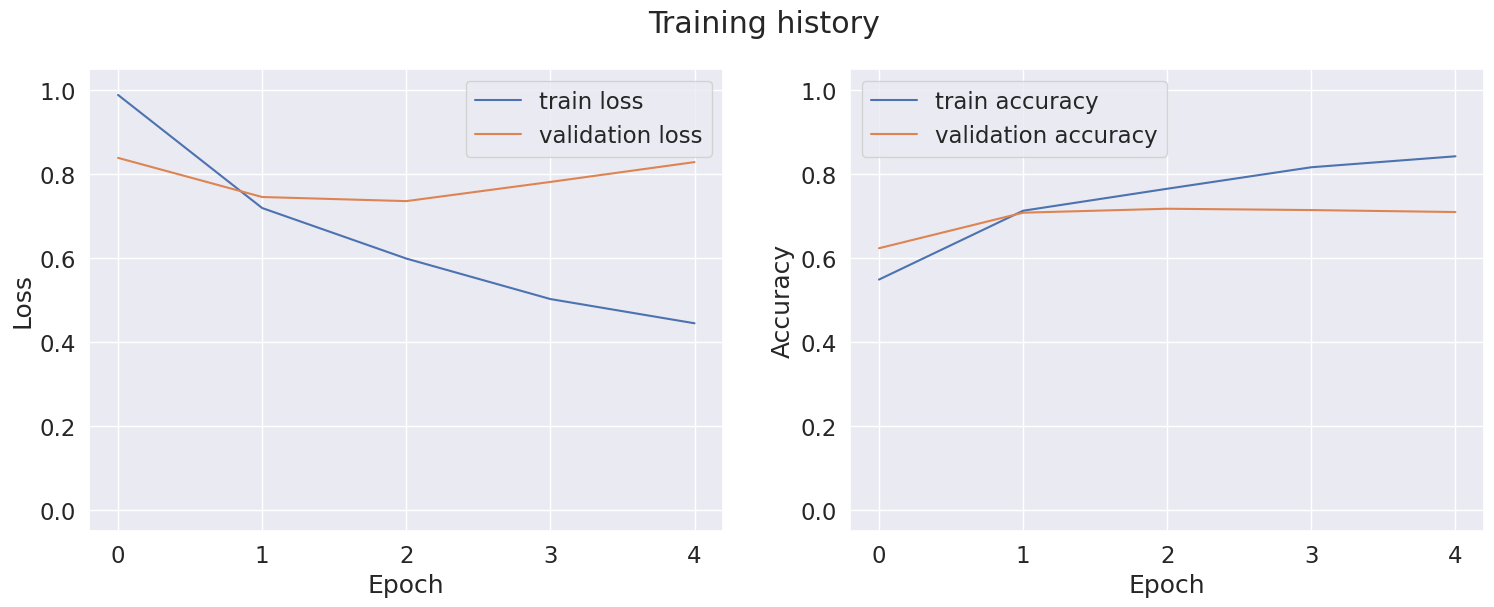

In [195]:
plot_training_history(training_stats)

## Evaluating Performance Over Training Set

In [196]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)


Creating Smart Batches from 5,100 examples with batch size 16...

Tokenizing 5,100 samples...
  Tokenized 0 samples.
  Tokenized 500 samples.
  Tokenized 1,000 samples.
  Tokenized 1,500 samples.
  Tokenized 2,000 samples.
  Tokenized 2,500 samples.
  Tokenized 3,000 samples.
  Tokenized 3,500 samples.
  Tokenized 4,000 samples.
  Tokenized 4,500 samples.
  Tokenized 5,000 samples.
DONE.
     5,100 samples

     5,100 samples after sorting

Creating batches of size 16...

  DONE - Selected 319 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 319 test batches...
  Batch      30  of      319.    Elapsed: 0:00:01.  Remaining: 0:00:07
  Batch      60  of      319.    Elapsed: 0:00:02.  Remaining: 0:00:07
  Batch      90  of      319.    Elapsed: 0:00:03.  Remaining: 0:00:06
  Batch     120  of      319.    Elapsed: 0:00:04.  Remaining: 0:00:06
  Batch     150  of      319.    Elapsed: 0:00:05.  Remaining: 0:00:05
  Batch     180  of      319.    Elapsed: 0

In [197]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    positive       0.86      0.89      0.87      1527
     neutral       0.87      0.83      0.85      1407
    negative       0.92      0.92      0.92      2166

    accuracy                           0.89      5100
   macro avg       0.88      0.88      0.88      5100
weighted avg       0.89      0.89      0.89      5100



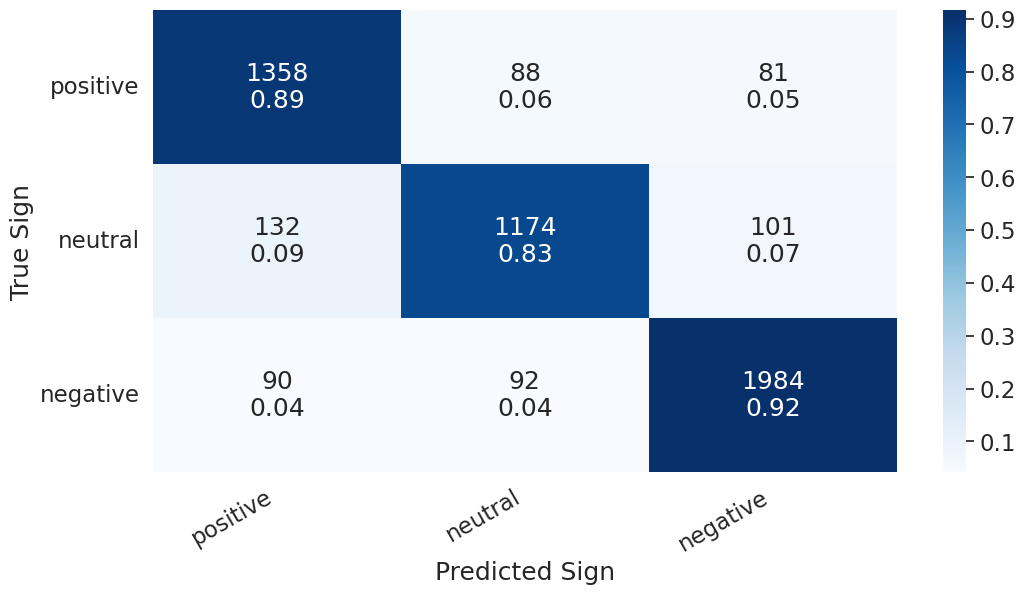

In [198]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Evaluating Performance Over Validation Set

In [199]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

Creating Smart Batches from 638 examples with batch size 16...

Tokenizing 638 samples...
  Tokenized 0 samples.
  Tokenized 60 samples.
  Tokenized 120 samples.
  Tokenized 180 samples.
  Tokenized 240 samples.
  Tokenized 300 samples.
  Tokenized 360 samples.
  Tokenized 420 samples.
  Tokenized 480 samples.
  Tokenized 540 samples.
  Tokenized 600 samples.
DONE.
       638 samples

       638 samples after sorting

Creating batches of size 16...

  DONE - Selected 40 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 40 test batches...
  Batch       4  of       40.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch       8  of       40.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      12  of       40.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      16  of       40.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      20  of       40.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      24  of       40.    Elapsed: 0:00:01.  Remaining: 0:00:

In [200]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    positive       0.66      0.69      0.68       190
     neutral       0.69      0.65      0.67       176
    negative       0.76      0.76      0.76       272

    accuracy                           0.71       638
   macro avg       0.70      0.70      0.70       638
weighted avg       0.71      0.71      0.71       638



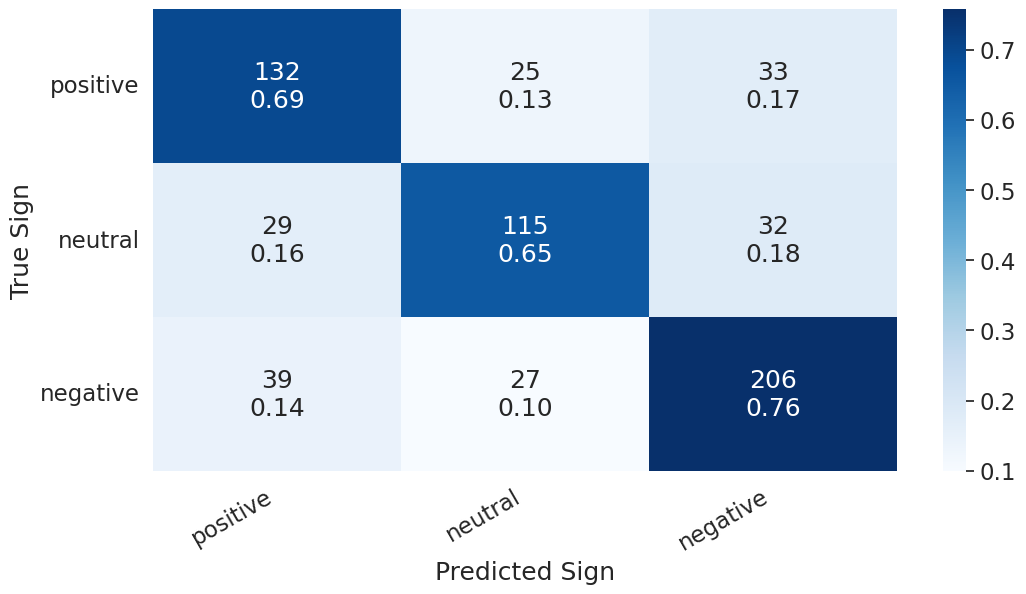

In [201]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Making Predictions on Test Set

In [202]:
test_df

,PID,text,labels
5344,5345,উলঙ্গ নারী দের পাসে রেখে ৯৬% মুসলমানের বাংলাদে...,negative
5300,5301,"হুজুরে আকা বাকা দোয়া করে দিয়েছেন , তাই ড্রাইভা...",neutral
5363,5364,জনগণের ট্যাক্সের টাকায় পদ্মা সেতু কিন্তু আবার...,neutral
349,350,ধন্যবাদ মানিয় শেখ হাসিনা ❤️❤️🤲,positive
5987,5988,তাহলে এখন পদ্মা সেতুতে ট্রাক চলাচল নিষিদ্ধ করা...,negative
...,...,...,...
598,599,পদ্মা সেতু বানাতে 30 হাজার কোটি টাকা খরচ হয় স...,negative
135,136,"অসাধারণ গান,শেখের বেটি আবার দেখিয়ে দিলো,শেখ হা...",positive
5971,5972,বেপরোয়া ড্রাইভিং-এর কারনে।,negative
4590,4591,"কথাই আছেভাত পাই না চা চাই,,,,,,।",positive


## Loading `test_sentences`

In [203]:
test_sentences = test_df['text'].values
test_labels = test_df['labels'].values
test_ids = test_df.index.values

In [204]:
test_ids

array([5344, 5300, 5363,  349, 5987, 3995,  561,  676, 4878, 1755,   17,
       2348,  254, 3066, 2273,  746, 1912,  543, 2765, 4855, 1926, 5360,
       3297,  371, 3221, 4119, 5217, 3460,  683,  198, 3703, 3908, 3133,
       3320, 2571, 2771, 2164, 2182, 1079,   93, 2688,    8, 3396, 5335,
       1615,  787, 1860, 5013, 5796, 3248, 3418,  764, 1039, 4600,  453,
       3740, 5549, 4672, 2638,  599, 1188, 3808, 2317, 5944, 1374, 1412,
       1161, 3258, 5332, 1362,  743, 1393,  828, 3505, 5887,  393, 2187,
         80, 2718, 4471,  439,  422,  877, 2579, 6136, 1480, 2948, 1354,
       6108, 5697, 1042, 4707, 3891, 5245, 4019, 3518, 2902, 1186,  932,
       5909, 5080, 5891, 3434, 5023,  121, 4445, 1483, 3459, 2670, 2202,
       3948, 5692, 4609, 4438, 3513, 3667,  977, 3563, 1197, 6282,  181,
       5723,  672, 3413, 6017, 3454, 3773, 1192, 5162, 3142, 2042,  151,
       3574, 5678, 1103, 1550, 1144, 2154, 4684, 1407, 4252,  907, 5037,
       4588,  323, 2646,  179, 2095, 5424, 2763, 60

In [205]:
(py_inputs, py_attn_masks,py_ids) = make_smart_batches_on_test(test_sentences,test_ids, 16,tokenizer,max_input_length)

Creating Smart Batches from 637 examples with batch size 16...

Tokenizing 637 samples...
  Tokenized 0 samples.
  Tokenized 60 samples.
  Tokenized 120 samples.
  Tokenized 180 samples.
  Tokenized 240 samples.
  Tokenized 300 samples.
  Tokenized 360 samples.
  Tokenized 420 samples.
  Tokenized 480 samples.
  Tokenized 540 samples.
  Tokenized 600 samples.
DONE.
       637 samples

       637 samples after sorting

Creating batches of size 16...

  DONE - Selected 40 batches.

Padding out sequences within each batch...
  DONE.


In [206]:
y_ids,y_preds  = get_predictions_test(py_inputs, py_attn_masks,py_ids)


Predicting labels for 40 test batches...
  Batch       4  of       40.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch       8  of       40.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      12  of       40.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      16  of       40.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      20  of       40.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      24  of       40.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      28  of       40.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      32  of       40.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      36  of       40.    Elapsed: 0:00:01.  Remaining: 0:00:00


In [207]:
test_sentences

array(['উলঙ্গ নারী দের পাসে রেখে ৯৬% মুসলমানের বাংলাদেশে যখন বিভিন্ন ধরনের কাজের সমাপ্তি ও উদ্ভোদন করা হয় তখন কি আমাদের রব রাগান্বিত হন না????',
       'হুজুরে আকা বাকা দোয়া করে দিয়েছেন , তাই ড্রাইভারা ও আকা বাকা ভাবেই গাড়ি চালাচ্চেন',
       'জনগণের ট্যাক্সের টাকায় পদ্মা সেতু কিন্তু আবার টোল উঠানো হয় বহুগুন বেশি। জুলুমের কারনে এই দূর গতি।',
       'ধন্যবাদ মানিয় শেখ হাসিনা ❤️❤️🤲',
       'তাহলে এখন পদ্মা সেতুতে ট্রাক চলাচল নিষিদ্ধ করা হোক।',
       'ডাইনিবুড়ি, কালনাগিনী',
       'আরে ভাই আল্লাহ তায়ালা যদি রক্ষা করলে কেউ কিছু করতে পারবেনা ।',
       'এই পদ্মা সেতু বিশ বছর কোনো সমস্যা ছাড়া গেলেই হলো।',
       'অসংখ্য ধন্যবাদ জানাচ্ছি মাননীয় প্রধানমন্ত্রী শেখ হাসিনাকে ❤️✌️',
       'এই উদ্বোধনী অনুষ্ঠান দেখতে আমিও গিয়েছিলাম।বিশাল আয়োজন ছিল।',
       'আলহামদুলিল্লাহ একটা নতুন অধ্যায় যোগ হলো বাংলাদেশ',
       'খুব বালো লাখছে বাই',
       'কলকাতা থেকে গান শুনলাম খুব ভালো লাগলো 🇮🇳🌹🌷🥀🙏',
       'চারিদিকে চোখ ঘোরালে শুধু শেখ হাসিনার উন্নয়ন আর অবদান',
       'মা সা আল্লাহপদ্মা সেতু কত কিলো

In [208]:
(py_inputs, py_attn_masks,py_ids) = make_smart_batches_on_test(test_sentences,test_ids, 16,tokenizer,max_input_length)
y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

Creating Smart Batches from 637 examples with batch size 16...

Tokenizing 637 samples...
  Tokenized 0 samples.
  Tokenized 60 samples.
  Tokenized 120 samples.
  Tokenized 180 samples.
  Tokenized 240 samples.
  Tokenized 300 samples.
  Tokenized 360 samples.
  Tokenized 420 samples.
  Tokenized 480 samples.
  Tokenized 540 samples.
  Tokenized 600 samples.
DONE.
       637 samples

       637 samples after sorting

Creating batches of size 16...

  DONE - Selected 40 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 40 test batches...
  Batch       4  of       40.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch       8  of       40.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      12  of       40.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      16  of       40.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      20  of       40.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      24  of       40.    Elapsed: 0:00:01.  Remaining: 0:00:

In [209]:
y_pred

array([0, 2, 0, 0, 0, 2, 2, 2, 0, 1, 2, 0, 0, 1, 2, 2, 2, 2, 1, 2, 0, 2,
       2, 0, 2, 1, 2, 2, 1, 1, 2, 2, 2, 0, 0, 1, 0, 0, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 0, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 2,
       2, 0, 1, 0, 1, 2, 2, 1, 0, 1, 1, 2, 2, 0, 2, 1, 0, 0, 2, 1, 0, 2,
       0, 0, 0, 2, 0, 2, 1, 1, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2,
       2, 1, 2, 0, 2, 0, 0, 2, 1, 0, 1, 2, 1, 0, 2, 0, 2, 2, 2, 2, 0, 2,
       0, 2, 2, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2, 2, 2, 0, 1, 1, 2, 1, 2,
       2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 0, 1, 1,
       0, 1, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 1, 2, 2, 2, 2, 2, 1,
       1, 2, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 1, 0, 0,
       0, 2, 2, 1, 0, 2, 1, 1, 0, 1, 2, 2, 2, 2, 2, 1, 1, 2, 0, 2, 0, 2,
       2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 0,
       0, 2, 0, 2, 2, 2, 2, 0, 1, 1, 2, 2, 0, 2, 1, 2, 1, 0, 2, 0, 1, 1,
       0, 1, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0,

## Evaluating accuracy over test set

In [210]:
y_ids,y_preds  = get_predictions_test(py_inputs, py_attn_masks,py_ids)


Predicting labels for 40 test batches...
  Batch       4  of       40.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch       8  of       40.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      12  of       40.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      16  of       40.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      20  of       40.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      24  of       40.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      28  of       40.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      32  of       40.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      36  of       40.    Elapsed: 0:00:01.  Remaining: 0:00:00


In [211]:
print(y_preds)

[0 2 0 0 0 2 2 2 0 1 2 0 0 1 2 2 2 2 1 2 0 2 2 0 2 1 2 2 1 1 2 2 2 0 0 1 0
 0 2 2 2 2 2 2 1 2 2 2 0 2 2 2 2 1 1 1 1 1 0 1 1 1 1 0 1 2 2 0 1 0 1 2 2 1
 0 1 1 2 2 0 2 1 0 0 2 1 0 2 0 0 0 2 0 2 1 1 0 2 0 2 2 2 2 0 0 0 2 0 2 2 2
 1 2 0 2 0 0 2 1 0 1 2 1 0 2 0 2 2 2 2 0 2 0 2 2 0 0 1 2 1 1 2 0 2 0 2 2 2
 0 1 1 2 1 2 2 1 2 2 2 2 1 2 1 1 1 2 2 2 1 2 1 1 1 0 1 1 0 1 2 0 2 0 0 2 0
 0 2 0 2 0 2 1 2 2 2 2 2 1 1 2 0 0 1 0 1 1 1 0 0 0 1 0 1 0 2 0 0 1 0 0 0 2
 2 1 0 2 1 1 0 1 2 2 2 2 2 1 1 2 0 2 0 2 2 0 2 0 2 2 2 2 0 2 0 2 2 0 1 2 2
 2 2 2 2 0 0 2 0 2 2 2 2 0 1 1 2 2 0 2 1 2 1 0 2 0 1 1 0 1 0 0 2 2 2 2 0 2
 2 2 2 0 0 2 2 2 0 2 1 1 2 2 0 2 0 2 1 2 2 1 2 2 0 0 2 2 1 2 2 0 0 1 2 0 0
 2 2 2 2 2 1 1 0 0 1 0 2 2 1 0 1 0 1 2 1 2 0 1 2 1 1 1 2 2 0 1 0 1 0 2 2 0
 0 2 2 1 2 2 2 2 0 1 0 0 2 2 0 2 1 0 0 0 2 0 0 0 2 0 0 0 0 2 2 2 2 2 1 0 1
 1 2 0 0 0 0 0 2 2 0 0 2 2 2 1 2 0 1 2 2 0 1 2 2 0 0 2 2 2 0 2 2 0 2 0 2 2
 0 0 0 1 1 1 2 0 0 2 1 0 1 0 2 0 2 0 2 0 2 0 1 2 2 0 2 2 0 2 0 2 2 2 1 2 2
 2 1 1 0 2 2 0 2 0 1 2 2 

In [212]:
print(y_ids)

[ 622 3703 3285 3011 1858 5251 4764 4554 5013 3434 3162 4060 2095 3333
 6357 2042 1488 4436  247 4678 1869 5325 5119 1079 1039 5332 1212  783
 1738 4275 1578 2251  691 4066 4376 3133 5497 2609 3849 1056 1144 2857
 5037 4922  672 5927 6138  354 2905 5657  503   88 4418 4316  538 1345
 1219   17 1860 2902 5891 2154 6005  576 2981 6194 5420 6275 2273 1926
 4600  599 4684 2018  265  472  230 4634  447 1941 5272 3551 5971 5987
  676 3066  877 5909 5692 3454   51 4039 3286 4823   75 1747 2699 2688
  453 2670 3866   65 4828  553 1090 5750 5925 2570 5129 3625 3256  598
 3670  217 2840 4302 1791 3189 1197 4334 4527 3808 4471 4453 3513  179
  445 4713 3258 5841 6219 5065 1499 4047 4441 5830 4119 1371  907 3025
 4949 5890 1433 3323  323  315 1411 3599  221 2970 4370  259 6150 6136
  932 2202 2550 1504 5072 2215 2542 2351  469  324 2615 3211 2227 4561
  367  439 6108 3459  977 6282 1550 2377 1084 3418 3705 5797 5108 4252
 4472 5360 4490 4091 6217 1244 3297 1385 4958 2833    8 1188   80 3948
  151 

In [213]:
le.inverse_transform(y_preds)

array(['negative', 'positive', 'negative', 'negative', 'negative',
       'positive', 'positive', 'positive', 'negative', 'neutral',
       'positive', 'negative', 'negative', 'neutral', 'positive',
       'positive', 'positive', 'positive', 'neutral', 'positive',
       'negative', 'positive', 'positive', 'negative', 'positive',
       'neutral', 'positive', 'positive', 'neutral', 'neutral',
       'positive', 'positive', 'positive', 'negative', 'negative',
       'neutral', 'negative', 'negative', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'neutral',
       'positive', 'positive', 'positive', 'negative', 'positive',
       'positive', 'positive', 'positive', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'negative', 'neutral', 'neutral',
       'neutral', 'neutral', 'negative', 'neutral', 'positive',
       'positive', 'negative', 'neutral', 'negative', 'neutral',
       'positive', 'positive', 'neutral', 'negative', 'neutral',
     

<Axes: xlabel='count'>

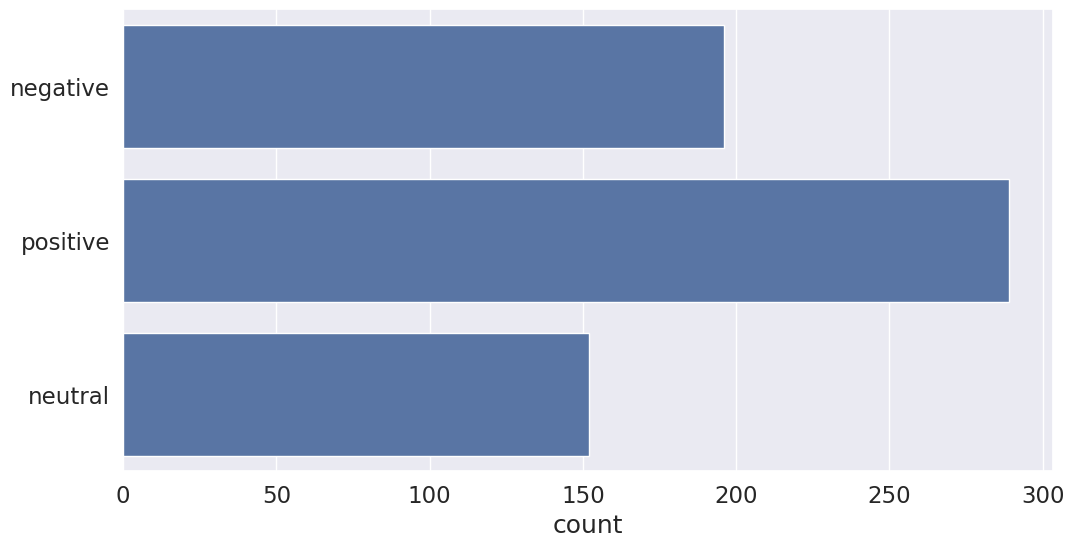

In [214]:
sns.countplot(y =le.inverse_transform(y_preds))

In [215]:
len(y_ids)

637

In [216]:
y_pred=le.inverse_transform(y_preds)
y_pred

array(['negative', 'positive', 'negative', 'negative', 'negative',
       'positive', 'positive', 'positive', 'negative', 'neutral',
       'positive', 'negative', 'negative', 'neutral', 'positive',
       'positive', 'positive', 'positive', 'neutral', 'positive',
       'negative', 'positive', 'positive', 'negative', 'positive',
       'neutral', 'positive', 'positive', 'neutral', 'neutral',
       'positive', 'positive', 'positive', 'negative', 'negative',
       'neutral', 'negative', 'negative', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'neutral',
       'positive', 'positive', 'positive', 'negative', 'positive',
       'positive', 'positive', 'positive', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'negative', 'neutral', 'neutral',
       'neutral', 'neutral', 'negative', 'neutral', 'positive',
       'positive', 'negative', 'neutral', 'negative', 'neutral',
       'positive', 'positive', 'neutral', 'negative', 'neutral',
     

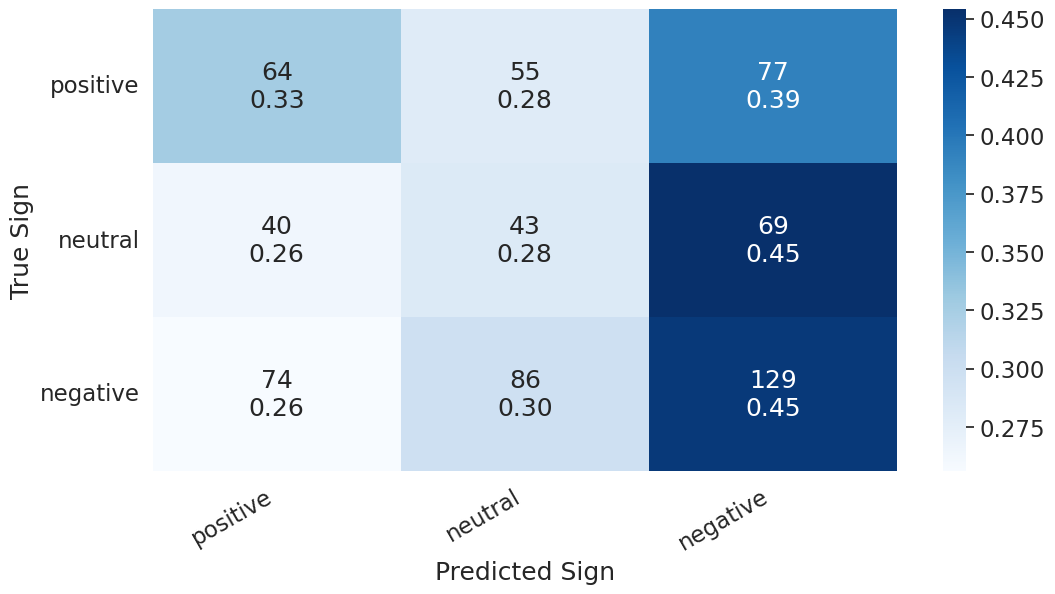

In [217]:
cm = confusion_matrix(y_pred, test_labels)
show_confusion_matrix(cm, class_names)

Classification Report:
              precision    recall  f1-score   support

    positive     0.3265    0.3596    0.3422       178
     neutral     0.2829    0.2337    0.2560       184
    negative     0.4464    0.4691    0.4574       275

    accuracy                         0.3705       637
   macro avg     0.3519    0.3541    0.3519       637
weighted avg     0.3657    0.3705    0.3671       637



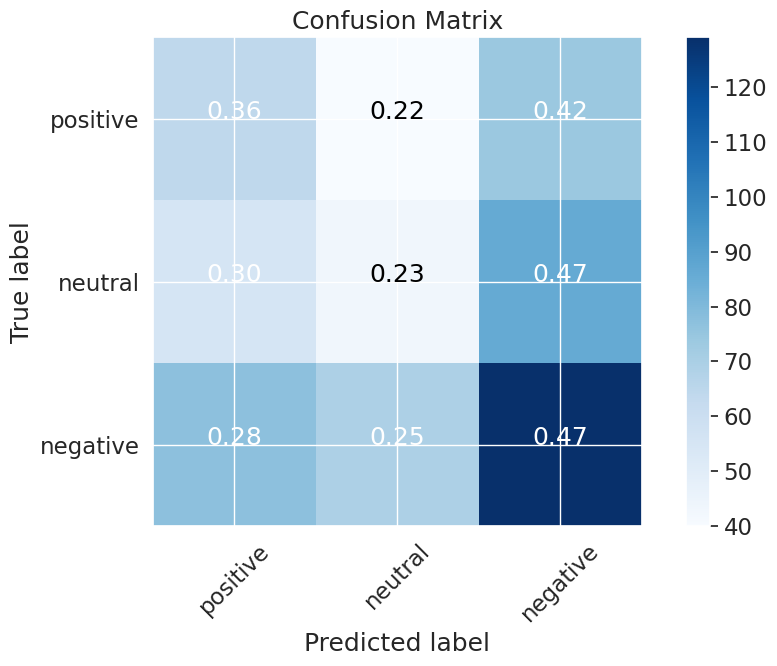

In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_pred and test_labels are defined
# Convert predictions to class labels if they are probabilities (if needed)
# y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the classification report
print("Classification Report:")
print(classification_report(test_labels, y_pred, target_names=class_names, zero_division=0, digits=4))

# Create the confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Function to display the confusion matrix
def show_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Normalize the confusion matrix by row (i.e., by the number of samples in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm_normalized.max() / 2.
    for i, j in np.ndindex(cm_normalized.shape):
        plt.text(j, i, format(cm_normalized[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Display the confusion matrix
show_confusion_matrix(cm, class_names)
